In [1]:
import glob
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from PIL import Image # pip install Pillow
import time
import math
import numpy as np
import scipy
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt

from morselib import *

Using TensorFlow backend.


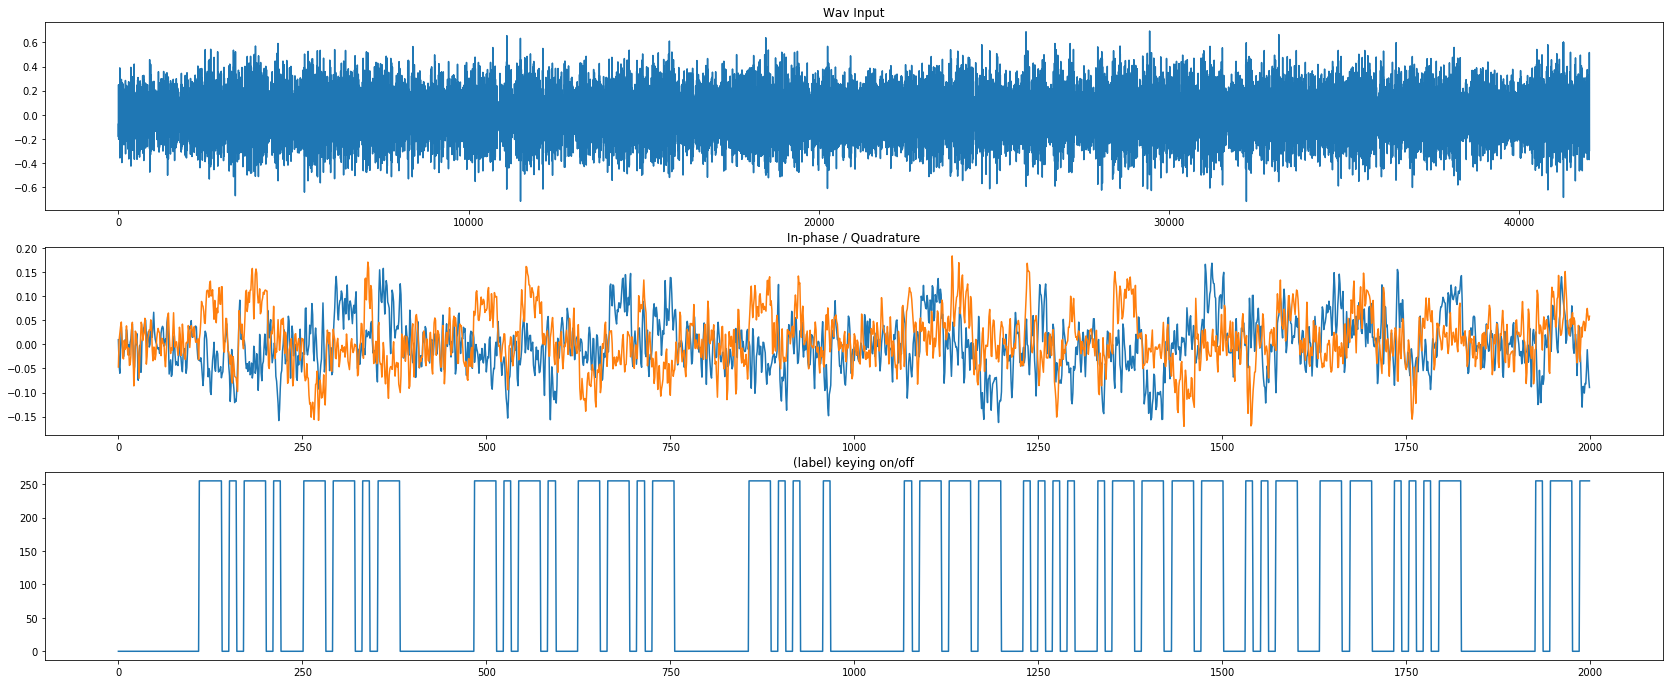

In [41]:
start = 100
end = start+2000

result_samplerate = 210

# load ./samples/10dB-25wpm-600Hz.ogg and ./samples/10dB-25wpm-600Hz-keying.png
wav_data = MorseWavData.load("./samples/2dB-25wpm-600Hz.ogg")
down_sampling_factor = math.floor(wav_data.samplerate / result_samplerate)

ch0, ch1, key, mid, rht = (d[start:end] for d in wav_data.get_iq(rsr = result_samplerate))


plt.figure(figsize=(29,20))
plt.subplot(511)
plt.title('Wav Input')
plt.plot(wav_data.wav[start*down_sampling_factor:end*down_sampling_factor])
plt.subplot(512)
plt.title('In-phase / Quadrature')
plt.plot(ch0)
plt.plot(ch1)
plt.subplot(513)
plt.title('(label) keying on/off')
plt.plot(key)
#plt.subplot(514)
#plt.title('morse code id')
#plt.plot(mid, '.')
#plt.subplot(515)
#plt.title('human recognizing timing')
#plt.plot(rht, '.')

plt.show()

In [42]:
model_file = "denoise/model/cnn_model34-loss0.06-val_acc0.98.hdf5"
print(model_file)
tstart = time.time()
keras.backend.clear_session()
model =  keras.models.load_model(model_file, compile=False)
elapsed = time.time() - tstart
print('load_model {}ms'.format(elapsed * 1000))
model.summary()
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])  

timestep = model.input.shape[1].value
features = model.input.shape[2].value

denoise/model/cnn_model34-loss0.06-val_acc0.98.hdf5
load_model 1901.585578918457ms
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 630, 2)       0                                            
__________________________________________________________________________________________________
input64a (Conv1D)               (None, 630, 64)      320         input_1[0][0]                    
__________________________________________________________________________________________________
bn_in (BatchNormalization)      (None, 630, 64)      256         input64a[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 630, 64)      0           bn_in[0][0]                      
__________________________

In [43]:
class MorseData:
    def __init__(self, wav_data, batch_size):

        ch0, ch1, key, mid, rht = wav_data.get_iq()
        print(ch0.shape, ch1.shape, key.shape)

        mag = min_max(np.sqrt(ch0 * ch0 + ch1 * ch1))
        pha = np.arctan2(ch0, ch1)
        var = np.absolute(np.convolve(np.cos(pha) + np.sin(pha)*1j, np.ones(5) / 5.0, mode='same'))
        var = min_max(var)
        x = np.concatenate(
                (
                    mag.reshape( (len(mag), 1) ),
                    var.reshape( (len(var), 1) ),
                ), 
                axis=1 
            )

        key = (key.astype('float32') / 255).reshape( (len(key), 1) )

        stride = 1
        start_index = 0

        self.tx = keras.preprocessing.sequence.TimeseriesGenerator(
                x,
                x,
                timestep,
                sampling_rate=1,
                stride=stride,
                start_index=start_index,
                end_index=None,
                shuffle=False,
                reverse=False,
                batch_size=batch_size
            )

        self.tkey = keras.preprocessing.sequence.TimeseriesGenerator(
                key,
                x,
                timestep,
                sampling_rate=1,
                stride=stride,
                start_index=start_index,
                end_index=None,
                shuffle=False,
                reverse=False,
                batch_size=batch_size
            )

        self.tmid = keras.preprocessing.sequence.TimeseriesGenerator(
                mid,
                x,
                timestep,
                sampling_rate=1,
                stride=stride,
                start_index=start_index,
                end_index=None,
                shuffle=False,
                reverse=False,
                batch_size=batch_size
            )

        self.trht = keras.preprocessing.sequence.TimeseriesGenerator(
                rht,
                x,
                timestep,
                sampling_rate=1,
                stride=stride,
                start_index=start_index,
                end_index=None,
                shuffle=False,
                reverse=False,
                batch_size=batch_size
            )
    def __len__(self):
        return len(self.tx)

    def get_x(self, index):
        return self.tx[index][0]

    def get_key(self, index):
        return self.tkey[index][0]

    def get_mid(self, index):
        return morse_code_categorical(self.tmid[index][0])

    def get_rht(self, index):
        return morse_code_categorical(self.trht[index][0])
    
data = MorseData(wav_data, 3000)

sx = data.get_x(index)
sy = data.get_key(index)

print(sx.shape, sy.shape)

tstart = time.time()
predicted = model.predict(np.reshape(sx, (len(sx), timestep, features)))
elapsed = time.time() - tstart
print('predict {}ms {}ms/sample ({} samples)'.format(elapsed * 1000, elapsed / len(predicted) * 1000, len(predicted)))

(4200,) (4200,) (4200,)
(3000, 630, 2) (3000, 630, 1)
predict 4310.862064361572ms 1.4369540214538574ms/sample (3000 samples)


500 3000 630


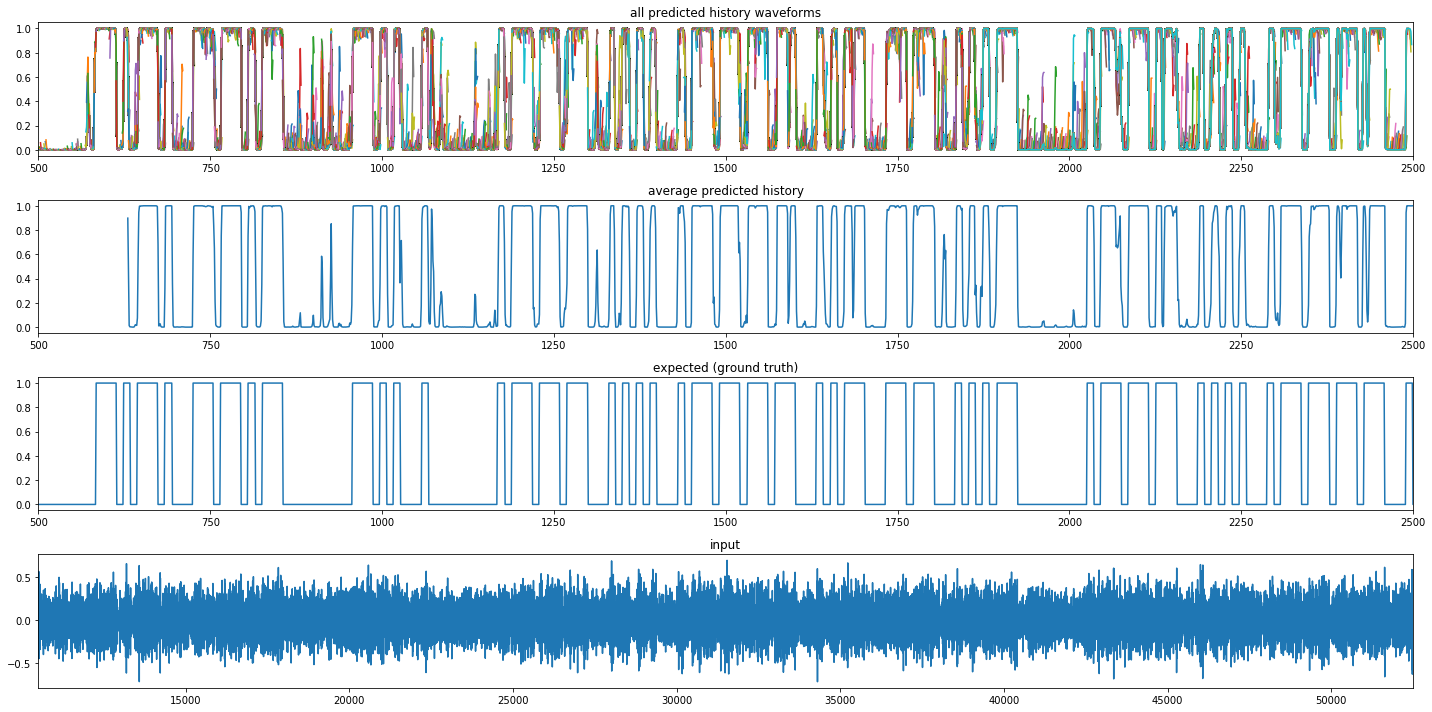

In [44]:
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.title('all predicted history waveforms')

start = 500
end = 3000

print(start, end, timestep)
for i in range(0, end-start-timestep):
    plt.plot( np.arange(i, i+timestep), predicted[i,:,0] )
plt.xlim(start, end-start)

plt.subplot(412)
plt.title('average predicted history')
#plt.plot( sx[:,0,0] )
#plt.plot( sx[:,0,1] )
mean_predicted = ([ np.array([predicted[i-j,j,0] for j in range(timestep)] ).mean() for i in range(timestep, end-start) ])
plt.plot( np.arange(timestep, end-start), mean_predicted )
plt.xlim(start, end-start)

plt.subplot(413)

plt.title('expected (ground truth)')
plt.plot(sy[:,0])
#plt.axvline(32)
plt.xlim(start, end-start)

plt.subplot(414)
plt.title('input')
#plt.plot(data.get_x(index)[:,0,:])
plt.plot(wav_data.wav[0:end*down_sampling_factor])
plt.xlim(start*down_sampling_factor, (end-start)*down_sampling_factor)
plt.tight_layout()
plt.show()